In [2]:
import tensorflow as tf
directory = '/content/celeba-dataset/img_align_celeba'

# Get all images from dir
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=directory, color_mode='rgb',
                                                   batch_size=128, image_size=(32,32), label_mode=None,
                                                   shuffle=True, seed=42)

# Normalize the data
dataset=dataset.map(lambda x: x /255.00)

Found 202599 files.


In [3]:
# Grid of image
from mpl_toolkits.axes_grid1 import ImageGrid

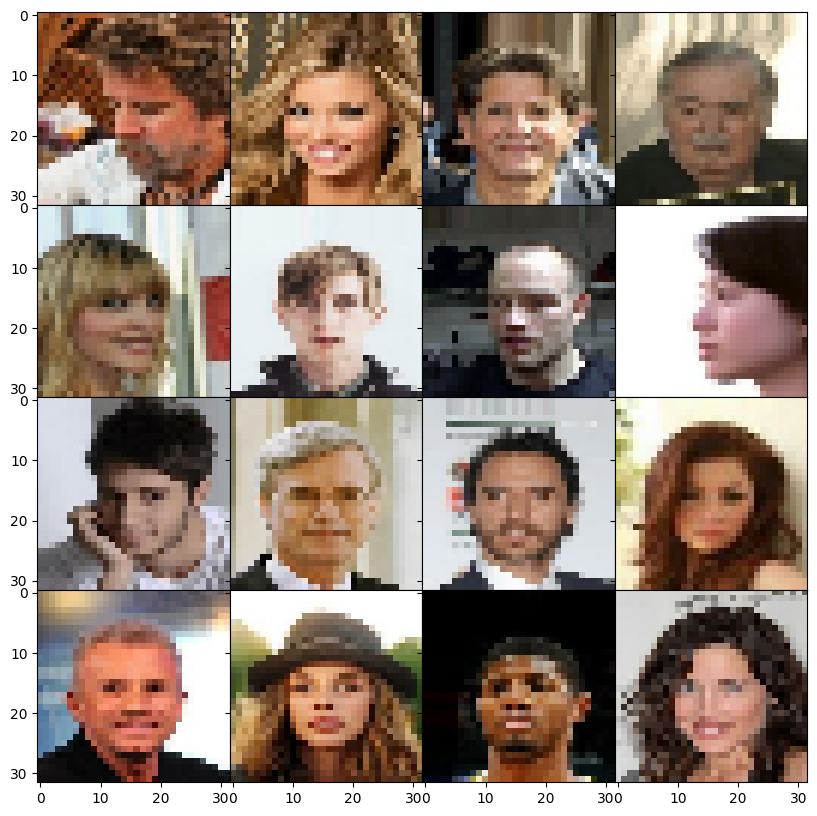

In [4]:
import matplotlib.pyplot as plt

it=iter(dataset)
one_batch = next(it).numpy()
images = one_batch[:16,:,:,:]

# show the image

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4,4),
         axes_pad=0)
for ax,im in zip(grid, images):
    ax.imshow(im)
plt.show()

In [5]:
from tensorflow.keras.layers import Conv2D, LeakyReLU,BatchNormalization, Dropout, Flatten, Dense, Activation, Reshape
from tensorflow.keras import Model, Input

def discriminator_model():
    disc_input = Input(shape=(32,32,3), name='discriminator_network')
    x=Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same')(disc_input)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)

    x=Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)

    x=Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)

    x=Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)

    x=Flatten()(x)
    x=Dense(1)(x)

    output = Activation('sigmoid')(x)

    disc=Model(inputs = disc_input, outputs=output)

    return disc

In [6]:
disc_model = discriminator_model()
disc_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ discriminator_network (InputLayer)   │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,281 (1.13 MB)

 Trainable params: 297,281 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dense, Reshape, Conv2DTranspose
from tensorflow.keras import Model, Input

def generator_model(z_dim=100):
    # Define input with the correct shape as a tuple
    gen_input = Input(shape=(z_dim,), name='generator_network')

    # First dense layer to reshape the input vector into an 8x8x3 tensor
    x = Dense(8*8*3)(gen_input)
    x = Reshape(target_shape=(8, 8, 3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Transpose convolution layers to upscale the image
    x = Conv2DTranspose(filters=512, kernel_size=3, strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=256, kernel_size=3, strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=64, kernel_size=3, strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Final layer to generate the image (3 channels for RGB)
    x = Conv2DTranspose(filters=3, kernel_size=3, strides=(1, 1), padding='same')(x)
    fake_images_gen = Activation('tanh')(x)  # Use tanh for pixel value scaling

    # Build the model
    model_gen = Model(inputs=gen_input, outputs=fake_images_gen)

    return model_gen

gen_model = generator_model()

In [8]:
gen_model.summary(0)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ generator_network (InputLayer)       │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 192)                 │          19,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 3)             │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 512)           │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 64)          │             2

 Total params: 1,736,143 (6.62 MB)

 Trainable params: 1,733,961 (6.61 MB)

 Non-trainable params: 2,182 (8.52 KB)

In [9]:
disc_model = discriminator_model()
gen_model = generator_model()
# Image Classification CNN
# Compile the model that trains disc.
disc_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

# Assuming the generator and discriminator models are already defined
z_dim = 100
disc_model.trainable = False  # Freeze the discriminator during the generator training

# Correct input shape as (z_dim,)
model_input = Input(shape=(z_dim,), name='model_input')

# Pass the generator's output to the discriminator
model_output = disc_model(gen_model(model_input))

# Create the combined model
model = Model(model_input, model_output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model (optional)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ model_input (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 32, 32, 3)           │       1,736,143 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 1)                   │         297,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,033,424 (7.76 MB)

 Trainable params: 1,733,961 (6.61 MB)

 Non-trainable params: 299,463 (1.14 MB)

In [11]:
import numpy as np
def train_discriminator(batch, batch_size):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    disc_model.train_on_batch(batch, valid)

    noise = np.random.normal(0,1, (batch_size, z_dim))
    gen_image = gen_model.predict(noise)
    disc_model.train_on_batch(gen_image, fake)

def train_generator(batch_size):
    valid = np.ones((batch_size, 1))
    noise = np.random.normal(0,1, (batch_size, z_dim))
    model.train_on_batch(noise, valid)

In [12]:
def save_image(fake_image, path):
    image = tf.keras.preprocessing.image.array_to_img(fake_image.numpy())
    tf.keras.preprocessing.image.save_img(path, image)
    return image

def generate_and_save_image(path):
    noise = np.random.normal(0,1, (1, z_dim))
    fake_images = gen_model(noise)
    image = save_image(fake_images[0], path)
    plt.imshow(image)
    plt.show()

In [14]:
import os
from PIL import Image

def create_gif(image_folder, gif_path, duration=500):
    # Get a list of image paths
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])

    # Open images and append them to a list
    images = [Image.open(os.path.join(image_folder, img)) for img in image_files]

    # Save images as a GIF
    images[0].save(
        gif_path, save_all=True, append_images=images[1:], duration=duration, loop=0
    )
    print(f"GIF saved at {gif_path}")

No of Epochs -> 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Batch Images -> 0


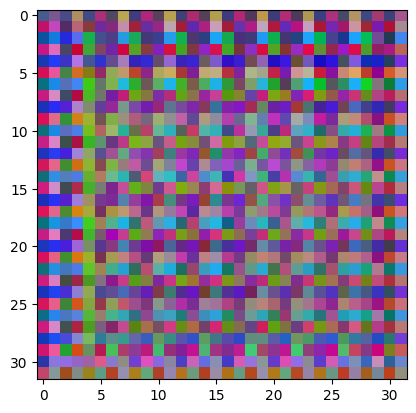

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

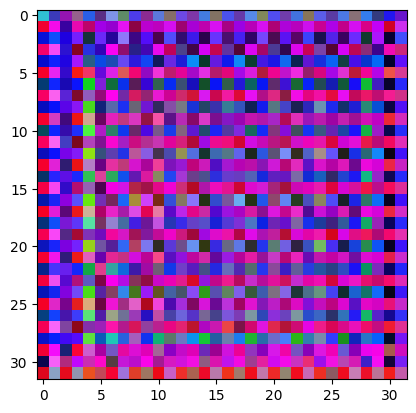

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

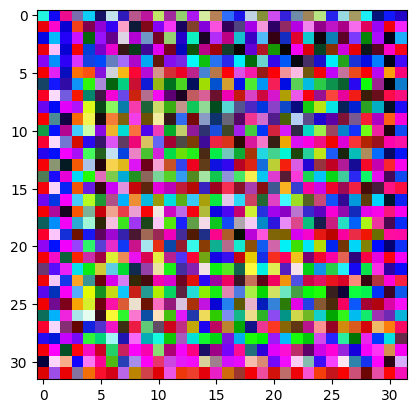

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

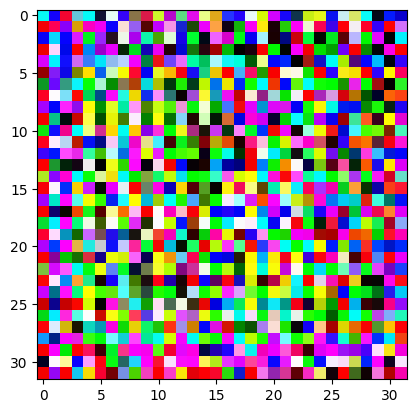

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
4/4 ━━━━━━

In [ ]:
# Training loop and image saving
for epochs in range(10):
    print(f'No of Epochs -> {epochs}')
    for i, batch in enumerate(dataset):
        train_discriminator(batch, batch.shape[0])
        train_generator(batch.shape[0])

        if i % 100 == 0:
            print(f'Batch Images -> {i}')
            PATH = 'generate_face'

            # Ensure the directory exists
            if not os.path.exists(PATH):
                os.makedirs(PATH)

            # Save the generated images
            generate_and_save_image(path=f'{PATH}/epochs_{epochs}_batch_{i}.jpg')